In [3]:
cd ..

/home/va0831/Projects


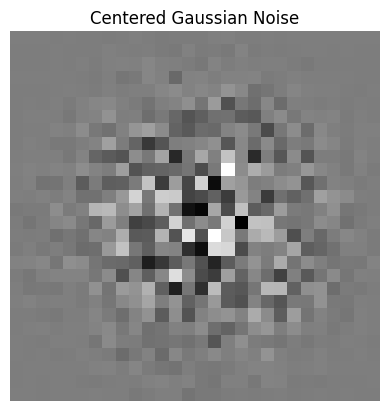

In [4]:
import os
import sys
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import  utils
import torch.nn.functional as F
from src.model import ConditionalUNet
from src.utils import set_seed,generate_centered_gaussian_noise
from src.dataset import get_data
set_seed(42)

# --- Configuración ---
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 128
timesteps = 100
img_shape = (1, 28, 28)
os.makedirs("outputs/flow_matching", exist_ok=True)
os.makedirs("outputs/flow_matching/images/", exist_ok=True)



# Generar imagen
img = generate_centered_gaussian_noise((1, 1, 28, 28))
img = (img-img.min())/(img.max()-img.min())
# Visualizar
plt.imshow(img[0, 0].numpy(), cmap='gray')
plt.title("Centered Gaussian Noise")
plt.axis('off')
plt.show()


In [ ]:
# --- Dataset ---
train_loader, val_loader = get_data(batch_size=batch_size,img_shape=img_shape)

# --- Flow Matching ---
def train_flow(epochs=1000,save_imgs=True,model_name="flow_model",use_localized_noise = False):    
    model = ConditionalUNet().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.0001)
    min_val_loss =np.inf

    for epoch in range(epochs):
        pbar = tqdm(train_loader, desc=f"[Train Epoch {epoch}]", leave=True, ncols=100)
        for x_real, y in pbar:
            x_real = x_real.to(device)
            y = y.to(device)
            if use_localized_noise:
                x_noise = generate_centered_gaussian_noise(x_real.shape).to(device)
            else:
                x_noise = torch.randn_like(x_real)
            
            t = torch.rand(x_real.size(0), device=device)
            x_t = (1 - t.view(-1, 1, 1, 1)) * x_noise + t.view(-1, 1, 1, 1) * x_real
            v_target = x_real - x_noise
            #t, x_t, v_target = FM.sample_location_and_conditional_flow(x_noise, x_real)
            v_pred = model(x_t, t, y)
            mse = torch.mean((v_pred - v_target) ** 2)
            norm_pred = F.log_softmax(v_pred.view(v_pred.size(0), -1), dim=1)
            norm_true = F.softmax(v_target.view(v_target.size(0), -1), dim=1)
            kl = F.kl_div(norm_pred, norm_true, reduction='batchmean')
            loss = mse# + 0.1 * kl

            opt.zero_grad()
            loss.backward()
            opt.step()

            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        model.eval()
        val_losses = []
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"[Val   Epoch {epoch}]", leave=True, ncols=100)
            for x_real, y in val_bar:
                x_real = x_real.to(device)
                y = y.to(device)
                if use_localized_noise:
                    x_noise = generate_centered_gaussian_noise(x_real.shape).to(device)
                else:
                    x_noise = torch.randn_like(x_real)
                t = torch.rand(x_real.size(0), device=device)
                x_t = (1 - t.view(-1, 1, 1, 1)) * x_noise + t.view(-1, 1, 1, 1) * x_real
                v_target = x_real - x_noise
                v_pred = model(x_t, t, y)
                mse = torch.mean((v_pred - v_target) ** 2)
                val_loss = mse
                val_losses.append(val_loss.item())
                val_bar.set_postfix({"loss": f"{np.mean(val_losses):.4f}"})

        avg_val_loss = np.mean(val_losses)
        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            print("Saving best model!")
            torch.save(model.state_dict(), f"outputs/flow_matching/{model_name}.pth")
        if (epoch + 1) % 10 == 0:
            if save_imgs:
                generate_flow(9, model=model, save_path=f"outputs/flow_matching/images/sample_epoch{epoch+1}.png",use_localized_noise=use_localized_noise)

    torch.save(model.state_dict(), f"outputs/flow_matching/{model_name}.pth")

# --- Generation Flow Conditional ---
@torch.no_grad()
def generate_flow(label, model=None, save_path=None, show=False,use_localized_noise=False):
    if model is None:
        model = ConditionalUNet().to(device)
        model.load_state_dict(torch.load("outputs/flow_matching/flow_model.pth"))
        model.eval()

    if use_localized_noise:
        x = generate_centered_gaussian_noise((64, *img_shape)).to(device)
    else:
        x = torch.randn(64, *img_shape).to(device)

    y = torch.full((64,), label, dtype=torch.long, device=device)
    steps = 50
    dt = 1.0 / steps

    for i in range(steps):
        t = torch.full((x.size(0),), i * dt, device=device)
        v = model(x, t, y)
        x = x + v * dt

    img = (x + 1) / 2
    utils.save_image(img, save_path or f"outputs/flow_matching/images/flow_gen_{label}.png", nrow=8)
    if show:
        plt.imshow(img[0].cpu().squeeze().numpy(), cmap='gray')
        plt.title(f'Generated {label}')
        plt.axis('off')
        plt.show()

# train_flow()
# generate_flow(9)
#train_flow(epochs=500,save_imgs=True,model_name="flow_model",use_localized_noise=False)
train_flow(epochs=500,save_imgs=True,model_name="flow_model_localized_noise",use_localized_noise=True)


